In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import re
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer


warnings.filterwarnings('ignore')
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

**Processing**

In [9]:
class TextProcessor(BaseEstimator, TransformerMixin):
    def __init__(self, lower=False, stem=False):
        self.lower = lower
        self.stem = stem

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        def text_processing(text):
            processed_text = re.sub('[^a-zA-Z]', ' ', text) # remove any non-alphabet characters
            if self.lower:
                processed_text = processed_text.lower()
            processed_text = processed_text.split()
            if self.stem:
                ps = PorterStemmer()
                processed_text = [ps.stem(word) for word in processed_text if word not in set(stopwords.words('english'))]
            processed_text = ' '.join(processed_text)
            return processed_text

        return [text_processing(text) for text in X]


In [10]:
file_path = 'emotion.txt'
data = pd.read_csv(file_path, sep=';', header=None, names=['Text', 'Emotion'])
data = data[~data['Emotion'].isin(['love', 'surprise'])]

label_encoder = LabelEncoder()
data['Emotion'] = label_encoder.fit_transform(data['Emotion'])

In [11]:
X = data['Text']
y = data['Emotion']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

text_pipeline = Pipeline([
    ('processor', TextProcessor(lower=True, stem=True)),
    ('vectorizer', TfidfVectorizer(max_features=5000))
])

In [12]:
X_train_processed = text_pipeline.fit_transform(X_train)
X_test_processed = text_pipeline.transform(X_test)

def create_model(optimizer='adam', dropout_rate=0.2):
    model = Sequential([
        Dense(128, input_dim=X_train_processed.shape[1], activation='relu'),
        Dropout(dropout_rate),
        Dense(64, activation='relu'),
        Dropout(dropout_rate),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [16]:
param_space = {
    'batch_size': Integer(32, 128),
    'epochs': Integer(10, 50),
    'optimizer': Categorical(['adam', 'rmsprop']),
    'dropout_rate': Real(0.1, 0.5)
}

model = KerasClassifier(build_fn=create_model, verbose=0, dropout_rate=0.31633689752874516)

**Hyperparamter Tuning using BayesSearchCV**

In [17]:
bayes_search = BayesSearchCV(
    model,
    search_spaces=param_space,
    n_iter=20,
    cv=3,
    verbose=2,
    n_jobs=-1
)

In [18]:
bayes_search.fit(X_train_processed, y_train)

best_model = bayes_search.best_estimator_
y_pred_train = best_model.predict(X_train_processed)
y_pred_test = best_model.predict(X_test_processed)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

In [19]:
print("Train Accuracy:", accuracy_score(y_train, y_pred_train))
print("Test Accuracy:", accuracy_score(y_test, y_pred_test))
print("\nTrain Classification Report:\n", classification_report(y_train, y_pred_train))
print("\nTest Classification Report:\n", classification_report(y_test, y_pred_test))

Train Accuracy: 0.15346490839897337
Test Accuracy: 0.1504424778761062

Train Classification Report:
               precision    recall  f1-score   support

           0       0.15      1.00      0.27      1734
           1       0.00      0.00      0.00      1553
           2       0.00      0.00      0.00      4267
           3       0.00      0.00      0.00      3745

    accuracy                           0.15     11299
   macro avg       0.04      0.25      0.07     11299
weighted avg       0.02      0.15      0.04     11299


Test Classification Report:
               precision    recall  f1-score   support

           0       0.15      1.00      0.26       425
           1       0.00      0.00      0.00       384
           2       0.00      0.00      0.00      1095
           3       0.00      0.00      0.00       921

    accuracy                           0.15      2825
   macro avg       0.04      0.25      0.07      2825
weighted avg       0.02      0.15      0.04      2825


In [27]:


# Plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()


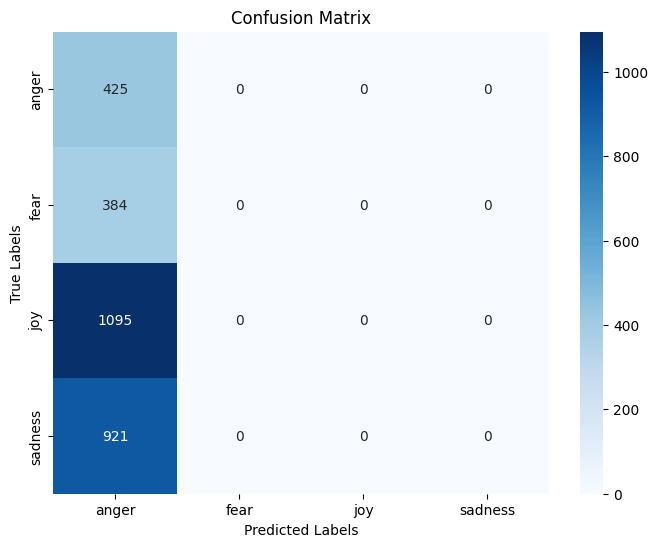

In [28]:
# Visualize confusion matrix
plot_confusion_matrix(y_test, y_pred_test, label_encoder.classes_)